In [24]:
import torch
import torch_geometric as pyg
import numpy as np
import matplotlib.pyplot as plt

First goal is to sample x, y from gaussian distrivution and treat these as cordinates of a node

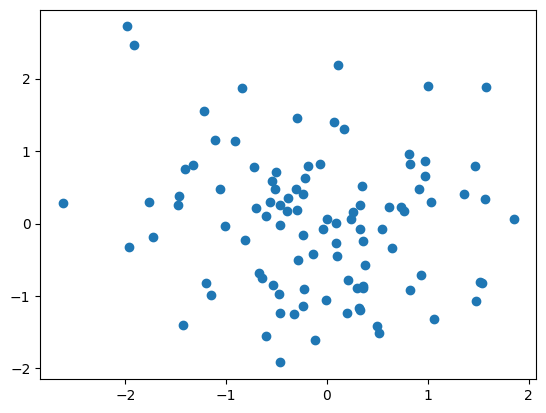

In [25]:
#create an array of [1 - 100] and then a row of x and y values randomly generated
np.random.seed(42)
NUM = 100
index_num = np.arange(0, NUM, 1)
x = np.random.normal(0, 1, NUM)
y = np.random.normal(0, 1, NUM)

#plot the x and y values
plt.scatter(x, y)
plt.show()


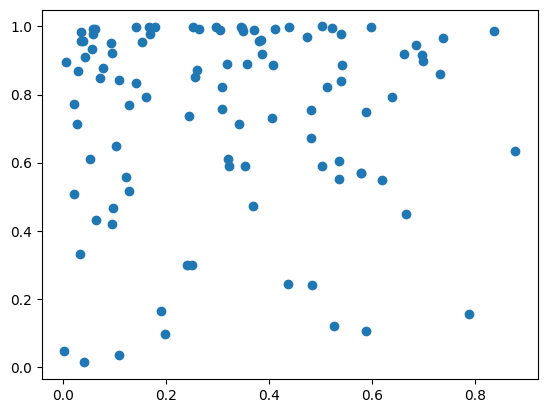

In [26]:
#lets use the beta distribution
np.random.seed(42)
NUM = 100
index_num = np.arange(0, NUM, 1)
x = np.random.beta(1, 2, NUM)
y = np.random.beta(1, 0.5, NUM)

#plot the x and y values
plt.scatter(x, y)

In [27]:
index_num

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [28]:
#create a numpy list of [name, x, y] for each point
data = np.array([index_num, x, y]).T
data.shape

(100, 3)

In [29]:
import torch
import pandas as pd
import numpy as np
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from  torch_geometric.transforms.distance import Distance 


def generate_dataset(numpy_array):
    #load the dataseT
    
    names = numpy_array[:, 0]
    #nodes = [f"{row[1]}-{row[0]}" for row in numpy_array]
    nodes = [f"{row[1]}" for row in numpy_array]
    edges = set()
    
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if i != j:
                edge = (i, j) if i < j else (j, i)  # Ensure a consistent order
                edges.add(edge)
    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    
    # pos = []
    # for row in numpy_array:
    #     import pdb; pdb.set_trace()
    #     pos.append([row[-2], row[-1]])
    
    pos = torch.tensor([[row[-2], row[-1]] for row in numpy_array], dtype=torch.float)


    #edges = [(i, j) for i in range(len(nodes)) for j in range(len(nodes)) if i != j]
    #edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    #pos = torch.tensor([[row[2], row[3]] for row in numpy_array], dtype=torch.float)
    #create a torch tesnor of the positions which is a random initialization betweem 0 and 1
    x = torch.tensor(np.random.rand(len(nodes)), dtype=torch.float) 
    data = Data(x=x, edge_index=edge_index)
    data.pos = pos
    #now compute the edge length 
    data = Distance(norm=False)(data)
#    torch.save(data, "/workspaces/masters_project/data/new_graph_dataset.pt")
    data.name = names
    
    return data

data = generate_dataset(data)

In [22]:
data

Data(x=[100], edge_index=[2, 4950], pos=[100, 2], edge_attr=[4950, 1], name=[100])

Now we got the dataset. Lets produce random subgraphs for them of size 50

In [30]:
def seperate_graph(graph):
    #obtain two subgraphs from the original graph
    #generate random integers from 0 -> number of nodes. Typically 50% of the nodes
    total_nodes_list = np.arange(0, len(graph.x), 1)
    random_nodes = np.random.choice(total_nodes_list, size=len(total_nodes_list)//2, replace=False)
    random_nodes = np.sort(random_nodes)
    second_nodes = np.setdiff1d(total_nodes_list, random_nodes) #this just gives indices
    second_nodes = np.sort(second_nodes)
    #get the elements of the total_nodes_list that are not in random_nodes
    
    #create the subgraphs
    #print(np.shape(random_nodes), np.shape(cleaned_nodes))
    random_nodes = torch.tensor(random_nodes, dtype=torch.long)
    second_nodes = torch.tensor(second_nodes, dtype=torch.long)
    edge_index_1, edge_attr_1 = pyg.utils.subgraph(random_nodes,
                                                    graph.edge_index, graph.edge_attr,
                                                     )
    
    
    edge_index_2, edge_attr_2 = pyg.utils.subgraph(second_nodes,
                                                    graph.edge_index, graph.edge_attr,
                                                     )
    # #create the subgraph data
    data_1 = Data(x=graph.x[random_nodes], edge_index=edge_index_1, edge_attr=edge_attr_1)
    data_1.pos = graph.pos[random_nodes]
    data_1.name = graph.name[random_nodes]
    
    data_2 = Data(x=graph.x[second_nodes], edge_index=edge_index_2, edge_attr=edge_attr_2)
    data_2.pos = graph.pos[second_nodes]
    data_2.name = graph.name[second_nodes]
    data_1.original_graph = torch.zeros(len(graph.x), dtype=torch.long)
    data_2.original_graph = torch.ones(len(graph.x), dtype=torch.long)
    return data_1,data_2

In [39]:
def seperate_graph_gnn(graph):
    #obtain two subgraphs from the original graph
    #generate random integers from 0 -> number of nodes. Typically 50% of the nodes
    total_nodes_list = np.arange(0, len(graph.x), 1)
    random_nodes = np.random.choice(total_nodes_list, size=len(total_nodes_list)//2, replace=False)
    random_nodes = np.sort(random_nodes)
    second_nodes = np.setdiff1d(total_nodes_list, random_nodes) #this just gives indices
    second_nodes = np.sort(second_nodes)
    #get the elements of the total_nodes_list that are not in random_nodes
    
    #create the subgraphs
    #print(np.shape(random_nodes), np.shape(cleaned_nodes))
    random_nodes = torch.tensor(random_nodes, dtype=torch.long)
    second_nodes = torch.tensor(second_nodes, dtype=torch.long)
    edge_index_1, edge_attr_1 = pyg.utils.subgraph(random_nodes,
                                                    graph.edge_index, graph.edge_attr,
                                                     relabel_nodes=True)
    if (edge_index_1.max() > len(random_nodes)) or (edge_index_1.min() < 0):
        print("error")
    edge_index_2, edge_attr_2 = pyg.utils.subgraph(second_nodes,
                                                    graph.edge_index, graph.edge_attr,
                                                    relabel_nodes=True )
    if (edge_index_2.max() > len(second_nodes)) or (edge_index_2.min() < 0):
        print("error with 1")
    # #create the subgraph data
    data_1 = Data(x=graph.x[random_nodes], edge_index=edge_index_1, edge_attr=edge_attr_1)
    data_1.pos = graph.pos[random_nodes]
    data_1.name = graph.name[random_nodes]
    
    data_2 = Data(x=graph.x[second_nodes], edge_index=edge_index_2, edge_attr=edge_attr_2)
    data_2.pos = graph.pos[second_nodes]
    data_2.name = graph.name[second_nodes]
    data_1.original_graph = torch.zeros(len(graph.x), dtype=torch.long)
    data_2.original_graph = torch.ones(len(graph.x), dtype=torch.long)

    #create a new graph. object that contains the original graph and the two subgraphs
    fin_graph = Data(x = data_1.x, edge_index = data_1.edge_index, edge_attr = data_1.edge_attr, pos_one = data_1.pos,
                      name_one = data_1.name, original_graph = data_1.original_graph,
                 x_two = data_2.x, edge_index_two = data_2.edge_index, edge_attr_two = data_2.edge_attr, pos_two = data_2.pos, name_two = data_2.name, original_graph_two = data_2.original_graph)

    return fin_graph

In [40]:
total_nodes_list = np.arange(0, 100, 1)
random_nodes = np.random.choice(total_nodes_list, size=len(total_nodes_list)//2, replace=False)
random_nodes = torch.tensor(np.sort(random_nodes))
second_nodes = np.setdiff1d(total_nodes_list, random_nodes)
second_nodes, random_nodes
print(random_nodes.shape, second_nodes.shape)

#generate random samples of 100 points
random_test = np.random.rand(100, 2)

random_test[second_nodes].shape

torch.Size([50]) (50,)


(50, 2)

In [41]:
NUM_TRAIN = 1000
np.random.seed(42)
data_vector = []

for i in range(NUM_TRAIN):
    x, y, names = np.random.beta(2, 2, NUM), np.random.normal(0, 0, NUM), np.arange(0, NUM, 1)
    data = np.array([names, x, y]).T
    data = generate_dataset(data)
    # graph_1, graph_2 = seperate_graph(data)
    # data_vector.append([graph_1, graph_2])
    data_vector.append(seperate_graph_gnn(data))


In [46]:
data_vector[1][0].x == data_vector[1][1].x
data_vector[1][0].name, data_vector[1][1].name  

(array([ 0.,  3.,  4.,  5.,  6.,  9., 13., 15., 18., 21., 22., 25., 27.,
        28., 31., 32., 33., 34., 35., 36., 38., 39., 40., 41., 42., 44.,
        48., 50., 51., 53., 54., 55., 57., 58., 60., 61., 64., 66., 67.,
        69., 72., 73., 75., 76., 80., 81., 84., 86., 96., 99.]),
 array([ 1.,  2.,  7.,  8., 10., 11., 12., 14., 16., 17., 19., 20., 23.,
        24., 26., 29., 30., 37., 43., 45., 46., 47., 49., 52., 56., 59.,
        62., 63., 65., 68., 70., 71., 74., 77., 78., 79., 82., 83., 85.,
        87., 88., 89., 90., 91., 92., 93., 94., 95., 97., 98.]))

TESTING

In [16]:
#save the data
torch.save(data_vector, "/workspaces/masters_project/notebooks/simplified_gnn_task/gnn_only_dataset.pt")

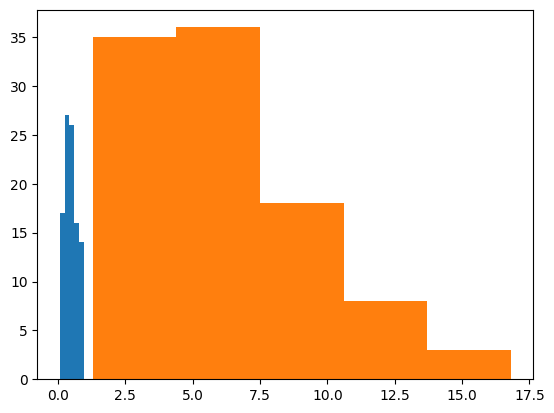

In [54]:
#create a histogram from x, y values
r = np.sqrt(x**2 + y**2)
plt.hist(r, bins=5)

x_temp = np.random.normal(0, 5, 100)
y_temp = np.random.normal(0, 5, 100)
r_temp = np.sqrt(x_temp**2 + y_temp**2)
#plot the histogram alongside 
plt.hist(r_temp, bins=5)
plt.show()

In [50]:
from scipy.spatial.distance import jensenshannon
def compute_jensen(value_1, value_2):
    #convert the histogram to a probability distribution
    #first compute the histogram
    #change this. 
    hist_1, bin_edges_1 = np.histogram(value_1, bins=5, density=True)
    hist_2, bin_edges_2 = np.histogram(value_2, bins=5, density=True)
    #compute the jensen shannon divergence
    hist_1 = hist_1 / np.sum(hist_1)
    hist_2 = hist_2 / np.sum(hist_2)
    return jensenshannon(hist_1, hist_2)

compute_jensen(r, r_temp)

0.1911945033352437